# Persiapan Dataset

## Import Library 

In [1]:
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('pystan').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [2]:
from tqdm import tqdm
from prophet import Prophet



from torchmetrics import MeanAbsolutePercentageError
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
import logging
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
# import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('pystan').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan/"

In [4]:
month_to_bulan={
    '01':'Januari',
    '02':'Februari',
    '03':'Maret',
    '04':'April',
    '05':'Mei',
    '06':'Juni',
    '07':'Juli',
    '08':'Agustus',
    '09':'September',
    '10':'Oktober',
    '11':'November',
    '12':'Desember'
}

bulan_to_month = dict(zip(month_to_bulan.values(),month_to_bulan.keys()))
bulan_to_month

{'Januari': '01',
 'Februari': '02',
 'Maret': '03',
 'April': '04',
 'Mei': '05',
 'Juni': '06',
 'Juli': '07',
 'Agustus': '08',
 'September': '09',
 'Oktober': '10',
 'November': '11',
 'Desember': '12'}

## Persiapan Dataset 

In [5]:
from datetime import datetime, timedelta
time = np.arange(np.datetime64("2013-08-26"),np.datetime64('today'))
time

array(['2013-08-26', '2013-08-27', '2013-08-28', ..., '2023-01-26',
       '2023-01-27', '2023-01-28'], dtype='datetime64[D]')

In [6]:
if os.path.isfile('tabel_emas.csv'):
    tabel_emas = pd.read_csv('tabel_emas.csv')
    if len(tabel_emas) < time.shape[0]:
        time_tambah = []
        nilai_emas  = []
        dolar_rp    = []
        for i in tqdm(range(len(time),len(tabel_emas))):
            day_str = np.datetime_as_string(time[i],unit='D').split('-')
            url = f"https://harga-emas.org/history-harga/{day_str[0]}/{month_to_bulan[day_str[1]]}/{day_str[2]}/"
            scrape_emas = pd.read_html(url)
            value_emas = float(scrape_emas[1][3][3].split()[0].replace('.',''))
            nilai_emas.append(value_emas)
            kurs_dol_rp = scrape_emas[1][2][2].split()[0].replace('.','').split(',')
            kurs_dol_rp = int(kurs_dol_rp[0]) + int(kurs_dol_rp[1])/(10**len(kurs_dol_rp[1]))
            dolar_rp.append(kurs_dol_rp)
        tambahan_tabel = pd.DataFrame({'tanggal':time_tambah,'harga_emas':nilai_emas,'kurs_dolar_rp':dolar_rp})
        tabel_emas = pd.concat([tabel_emas,tambahan_tabel])
else:
    nilai_emas = []
    dolar_rp   = []
    for i in tqdm(range(len(time))):
        day_str = np.datetime_as_string(time[i],unit='D').split('-')
        url = f"https://harga-emas.org/history-harga/{day_str[0]}/{month_to_bulan[day_str[1]]}/{day_str[2]}/"
        scrape_emas = pd.read_html(url)
        
        value_emas = float(scrape_emas[1][3][3].split()[0].replace('.',''))
        nilai_emas.append(value_emas)

        kurs_dol_rp = scrape_emas[1][2][2].split()[0].replace('.','').split(',')
        kurs_dol_rp = int(kurs_dol_rp[0]) + int(kurs_dol_rp[1])/(10**len(kurs_dol_rp[1]))
        dolar_rp.append(kurs_dol_rp)

    tabel_emas = pd.DataFrame({'tanggal':time,'harga_emas':nilai_emas,'kurs_dolar_rp':dolar_rp})
    tabel_emas.to_csv('tabel_emas.csv',index=False)
tabel_emas.tanggal = pd.to_datetime(tabel_emas.tanggal)
    
#15 menitan kuranglah

0it [00:00, ?it/s]


## Data Corona

<AxesSubplot: xlabel='date', ylabel='new_cases'>

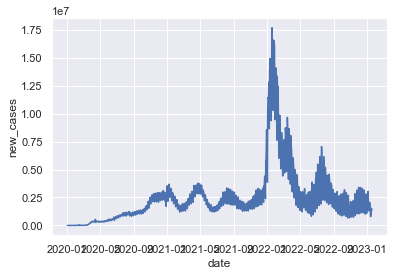

In [7]:
# data berasal https://covid.ourworldindata.org/data/owid-covid-data.csv
data_corona = pd.read_csv('owid-covid-data.csv')

# data_corona.columns
data_corona = data_corona.groupby('date')['new_cases'].sum()
data_corona = pd.DataFrame(data_corona)
data_corona = data_corona.reset_index()
data_corona.date = pd.to_datetime(data_corona.date)
data_corona = data_corona.sort_values('date')
sns.set_theme()
sns.lineplot(data=data_corona ,x='date',y='new_cases')

## Merge Data Corona

In [8]:
tabel_emas = pd.merge(tabel_emas,data_corona,how='left',left_on='tanggal',right_on='date')
tabel_emas = tabel_emas.drop('date',axis=1)
tabel_emas.new_cases = tabel_emas.new_cases.fillna(0)
tabel_emas = tabel_emas.rename({'new_cases':'n_case_corona'},axis=1)
tabel_emas

,tanggal,harga_emas,kurs_dolar_rp,n_case_corona
0,2013-08-26,498952.0,11140.0,0.0
1,2013-08-27,513169.0,11247.5,0.0
2,2013-08-28,524389.0,11491.0,0.0
3,2013-08-29,518760.0,11441.0,0.0
4,2013-08-30,511792.0,11378.5,0.0
...,...,...,...,...
3429,2023-01-15,948727.0,15366.0,783161.0
3430,2023-01-16,933959.0,15177.0,884526.0
3431,2023-01-17,923464.0,15019.0,1430351.0
3432,2023-01-18,929860.0,15154.0,1532241.0


## Data Inflasi

In [9]:
data_inflasi         = pd.read_excel('Data Inflasi.xlsx')
data_inflasi.columns = data_inflasi.iloc[3,:].tolist()
data_inflasi         = data_inflasi.iloc[4:,:3]
data_inflasi.drop('No',axis=1,inplace=True)
data_inflasi.Periode =  data_inflasi.Periode.apply(lambda x : x.split()[1] + '-' + bulan_to_month[x.split()[0]])
data_inflasi['Data Inflasi'] =  data_inflasi['Data Inflasi'].apply(lambda x : float(x.split()[0]))
data_inflasi.sort_values('Periode',inplace=True)
data_inflasi.reset_index(inplace=True,drop=True)
data_inflasi.Periode = pd.to_datetime(data_inflasi.Periode)
data_inflasi

,Periode,Data Inflasi
0,2014-08-01,3.99
1,2014-09-01,4.53
2,2014-10-01,4.83
3,2014-11-01,6.23
4,2014-12-01,8.36
...,...,...
96,2022-08-01,4.69
97,2022-09-01,5.95
98,2022-10-01,5.71
99,2022-11-01,5.42


In [10]:
import itertools

def grid_dict(my_dict):
    keys, values = zip(*my_dict.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return permutations_dicts

In [11]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error

def grid_search_pr(dataku):
    param_grid = {'growth': ['linear'],
              'changepoint_prior_scale': [0.01,0.05, 0.1,0.2,0.3,0.4,
                                            0.5,0.6,0.7,0.8,0.9 ,1.0,2,3,4,5,6,7,8,9,10,11,12],
              'seasonality_prior_scale':[0.01,0.05, 0.1,0.2,0.3,0.4,
                                            0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12],
              'seasonality_mode':['additive','multiplicative']
              }
    param_grid_list = grid_dict(param_grid)

    pembagian_train = int(len(dataku)*0.8)
    dataku.columns = ['ds','y']
    dataku_tr = dataku[:pembagian_train]
    dataku_te = dataku[pembagian_train:]

    hasil_met = []
    for param in tqdm(param_grid_list):
        model = Prophet(**param)
        model.fit(dataku_tr)
        future = model.make_future_dataframe(len(dataku_te),freq='M')
        forecast = model.predict(future)
        prediksi = forecast['yhat'][pembagian_train:]
        mapeku = mean_absolute_percentage_error(dataku_te.y,prediksi)
        hasil_met.append(mapeku)
    jawaban = hasil_met.index(min(hasil_met))
    param = param_grid_list[jawaban]
    dataframeku = pd.DataFrame(param_grid_list)
    dataframeku['mape'] = hasil_met
    dataframeku = dataframeku.sort_values('mape')
    return (dataframeku,param)

In [12]:
data_inflasi_pr         = data_inflasi.copy()
dataframeku , best_param = grid_search_pr(data_inflasi_pr)
print('='*64)
print(best_param)
print(dataframeku.head())

  0%|          | 0/1058 [00:00<?, ?it/s]12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/1058 [00:02<37:50,  2.15s/it]12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/1058 [00:02<22:36,  1.28s/it]12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/1058 [00:03<18:52,  1.07s/it]12:41:07 - cmdstanpy - INFO - Chain [1] start processing
12:41:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/1058 [00:04<17:53,  1.02s/it]12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 5/1058 [00:05<15:50,  1.11it/s]12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/1058 [00:06<15:12,  1.1

{'growth': 'linear', 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
     growth  changepoint_prior_scale  seasonality_prior_scale  \
93   linear                      0.1                     0.01   
111  linear                      0.1                     0.80   
123  linear                      0.1                     5.00   
127  linear                      0.1                     7.00   
105  linear                      0.1                     0.50   

    seasonality_mode      mape  
93    multiplicative  0.474179  
111   multiplicative  0.477891  
123   multiplicative  0.477934  
127   multiplicative  0.478131  
105   multiplicative  0.478156  


In [13]:
dataframeku

,growth,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mape
93,linear,0.1,0.01,multiplicative,0.474179
111,linear,0.1,0.80,multiplicative,0.477891
123,linear,0.1,5.00,multiplicative,0.477934
127,linear,0.1,7.00,multiplicative,0.478131
105,linear,0.1,0.50,multiplicative,0.478156
...,...,...,...,...,...
599,linear,3.0,0.01,multiplicative,0.958413
553,linear,2.0,0.01,multiplicative,0.959686
556,linear,2.0,0.10,additive,0.961297
552,linear,2.0,0.01,additive,0.965867


20:49:40 - cmdstanpy - INFO - Chain [1] start processing
20:49:40 - cmdstanpy - INFO - Chain [1] done processing


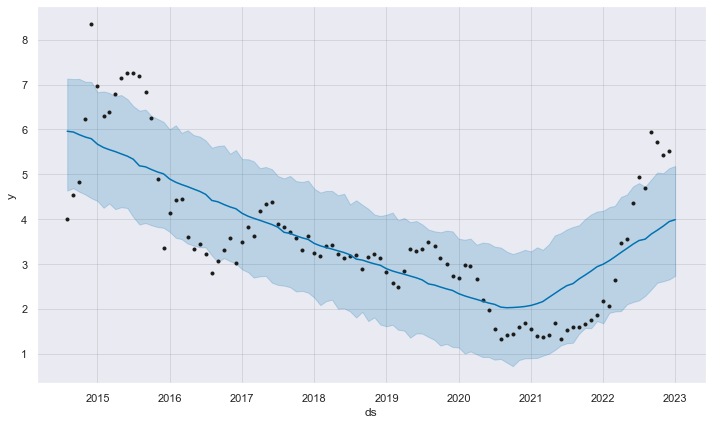

In [14]:
data_inflasi_pr.columns = ['ds','y']
model_pr_inflasi        = Prophet(**best_param)
model_pr_inflasi.fit(data_inflasi_pr)
future = model_pr_inflasi.make_future_dataframe(1,freq='M')
forecast = model_pr_inflasi.predict(future)
model_pr_inflasi.plot(forecast)
plt.show()

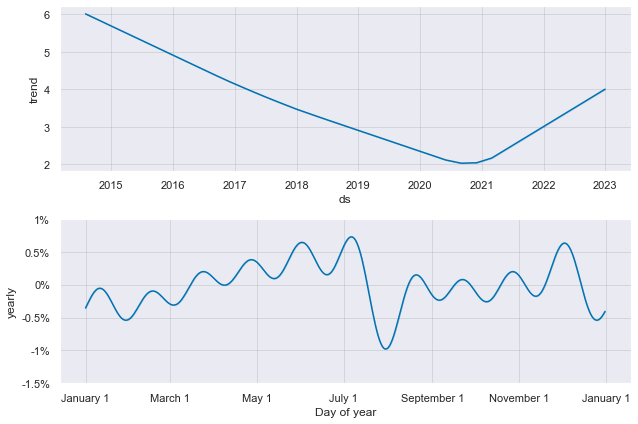

In [15]:
model_pr_inflasi.plot_components(forecast)
plt.show()

In [ ]:
forecast

In [17]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-08-01,6.015706,4.634122,7.131364,6.015706,6.015706,-0.009652,-0.009652,-0.009652,-0.009652,-0.009652,-0.009652,0.0,0.0,0.0,5.957644
1,2014-09-01,5.949600,4.687851,7.120846,5.949600,5.949600,-0.001555,-0.001555,-0.001555,-0.001555,-0.001555,-0.001555,0.0,0.0,0.0,5.940351
2,2014-10-01,5.885628,4.608826,7.124666,5.885628,5.885628,-0.000945,-0.000945,-0.000945,-0.000945,-0.000945,-0.000945,0.0,0.0,0.0,5.880064
3,2014-11-01,5.819523,4.545221,7.059905,5.819523,5.819523,0.001375,0.001375,0.001375,0.001375,0.001375,0.001375,0.0,0.0,0.0,5.827526
4,2014-12-01,5.755550,4.463981,7.057646,5.755550,5.755550,0.006143,0.006143,0.006143,0.006143,0.006143,0.006143,0.0,0.0,0.0,5.790905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2022-09-01,3.670210,2.429014,4.881744,3.670210,3.670210,-0.001555,-0.001555,-0.001555,-0.001555,-0.001555,-0.001555,0.0,0.0,0.0,3.664504
98,2022-10-01,3.752521,2.577850,5.036868,3.752521,3.752521,-0.000945,-0.000945,-0.000945,-0.000945,-0.000945,-0.000945,0.0,0.0,0.0,3.748973
99,2022-11-01,3.837576,2.612156,5.022530,3.837576,3.837576,0.001375,0.001375,0.001375,0.001375,0.001375,0.001375,0.0,0.0,0.0,3.842853
100,2022-12-01,3.919887,2.653449,5.134387,3.919887,3.919887,0.006143,0.006143,0.006143,0.006143,0.006143,0.006143,0.0,0.0,0.0,3.943966


<AxesSubplot: xlabel='tanggal', ylabel='harga_emas'>

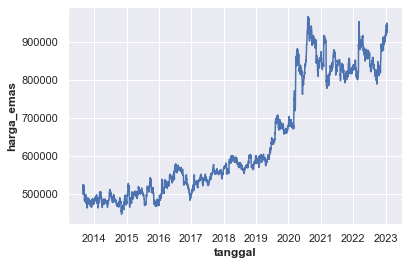

In [ ]:
sns.lineplot(tabel_emas,x='tanggal',y='harga_emas')

<AxesSubplot: xlabel='tanggal', ylabel='n_case_corona'>

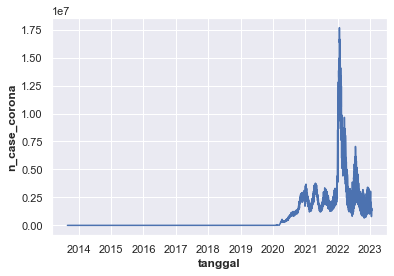

In [129]:
sns.lineplot(tabel_emas,x='tanggal',y='n_case_corona')

<AxesSubplot: xlabel='tanggal', ylabel='kurs_dolar_rp'>

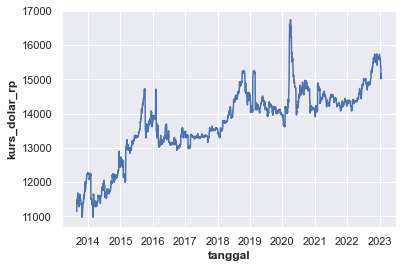

In [130]:
sns.lineplot(tabel_emas,x='tanggal',y='kurs_dolar_rp')

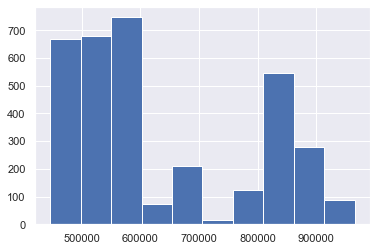

In [131]:
tabel_emas.harga_emas.hist()
plt.show()

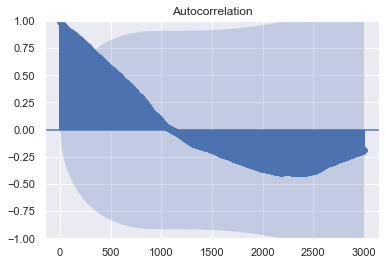

In [132]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(tabel_emas.harga_emas, lags=3000)
plt.show()

c:\Users\ASUS\.conda\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


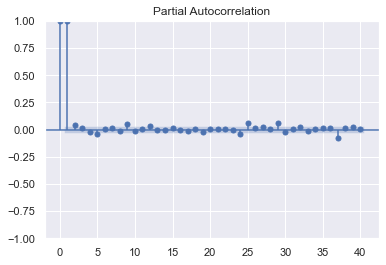

In [133]:
sm.graphics.tsa.plot_pacf(tabel_emas.harga_emas, lags=40)
plt.show()

In [134]:
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality,plot_hist,plot_residuals_analysis
from darts.utils.model_selection import train_test_split
from darts import TimeSeries

ts_emas = TimeSeries.from_dataframe(tabel_emas,'tanggal','harga_emas')
ts_emas_tr , ts_emas_te = train_test_split(ts_emas,test_size=0.2)
print('check seasonality',check_seasonality(ts_emas))

check seasonality (False, 0)


In [135]:

# from darts.models import TFTModel,NBEATSModel
# from darts.metrics import mse,mape
# ts_emas = TimeSeries.from_dataframe(tabel_emas,'tanggal','harga_emas')
# model_tft = TFTModel(input_chunk_length=365, output_chunk_length=180,add_relative_index=True)
# model_tft.fit(ts_emas_tr)
# prediction = model_tft.predict(len(ts_emas_te))
# mse_tft = mse(ts_emas_te,prediction)
# mape_tft = mape(ts_emas_te,prediction)
# print('hasil MSE :',mse(ts_emas_te,prediction))
# ts_emas_tr.plot(label='train')
# ts_emas_te.plot(label='test')
# prediction.plot(label='prediksi')
# plt.show()

In [136]:
# from darts.models import TFTModel,NBEATSModel
# model_nbeats = NBEATSModel(input_chunk_length=365, output_chunk_length=365,dropout=0.2)
# model_nbeats.fit(ts_emas_tr)
# prediction = model_nbeats.predict(len(ts_emas_te),mc_dropout=True)
# mse_nbeats = mse(ts_emas_te,prediction)

# print('hasil MSE :',mse(ts_emas_te,prediction))
# ts_emas_tr.plot(label='train')
# ts_emas_te.plot(label='test')
# prediction.plot(label='prediksi')
# plt.show()

In [137]:
# from darts.models import TFTModel,NBEATSModel,NHiTSModel
# model_nhits = NHiTSModel(input_chunk_length=365, output_chunk_length=365,dropout=0.2)
# model_nhits.fit(ts_emas_tr)
# prediction = model_nhits.predict(len(ts_emas_te),mc_dropout=True)
# mse_nhits = mse(ts_emas_te,prediction)
# print('hasil MSE :',mse(ts_emas_te,prediction))
# ts_emas_tr.plot(label='train')
# ts_emas_te.plot(label='test')
# prediction.plot(label='prediksi')
# plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 751 K 
---------------------------------------------------
751 K     Trainable params
0         Non-trainable params
751 K     Total params
6.015     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

hasil MSE : 57118936451.05594


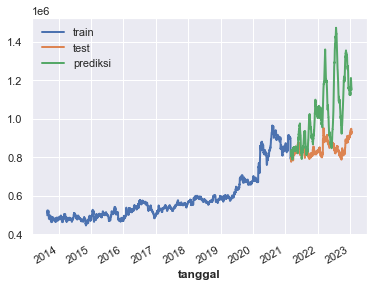

In [138]:
from darts.models import TFTModel,NBEATSModel,NHiTSModel,NLinearModel
from darts.metrics import mape,mse
from torchmetrics import MeanSquaredError

model_nlinear = NLinearModel(input_chunk_length=365*3, 
                            output_chunk_length=len(ts_emas_te),
                            torch_metrics=MeanSquaredError(),
                            normalize=True)
model_nlinear.fit(ts_emas_tr)
prediction = model_nlinear.predict(len(ts_emas_te),mc_dropout=True)
mse_nlinear = mse(ts_emas_te,prediction)
mape_nlinear = mape(ts_emas_te,prediction)
print('hasil MSE :',mse(ts_emas_te,prediction))
ts_emas_tr.plot(label='train')
ts_emas_te.plot(label='test')
prediction.plot(label='prediksi')
plt.show()

In [139]:
# print(f'MSE NHits  : {mse_nhits}')
# print(f'MSE NBeats : {mse_nbeats}')
# print(f'MSE TFT    : {mse_tft}')
# print(f'MSE RNN    : {mse_rnn}')
print(f'MSE Nlinear: {mse_nlinear}')

MSE Nlinear: 57118936451.05594


In [140]:
tabel_emas

,tanggal,harga_emas,kurs_dolar_rp,n_case_corona
0,2013-08-26,498952.0,11140.0,0.0
1,2013-08-27,513169.0,11247.5,0.0
2,2013-08-28,524389.0,11491.0,0.0
3,2013-08-29,518760.0,11441.0,0.0
4,2013-08-30,511792.0,11378.5,0.0
...,...,...,...,...
3429,2023-01-15,948727.0,15366.0,783161.0
3430,2023-01-16,933959.0,15177.0,884526.0
3431,2023-01-17,923464.0,15019.0,1430351.0
3432,2023-01-18,929860.0,15154.0,1532241.0


In [141]:
forecast[['ds','yhat']][-bagi_ruang_test:]

,ds,yhat
2748,2021-03-05,9.182492e+05
2749,2021-03-06,9.194420e+05
2750,2021-03-07,9.205757e+05
2751,2021-03-08,9.222210e+05
2752,2021-03-09,9.263386e+05
...,...,...
3429,2023-01-15,1.281211e+06
3430,2023-01-16,1.274493e+06
3431,2023-01-17,1.269167e+06
3432,2023-01-18,1.274992e+06


14:47:24 - cmdstanpy - INFO - Chain [1] start processing
14:47:26 - cmdstanpy - INFO - Chain [1] done processing


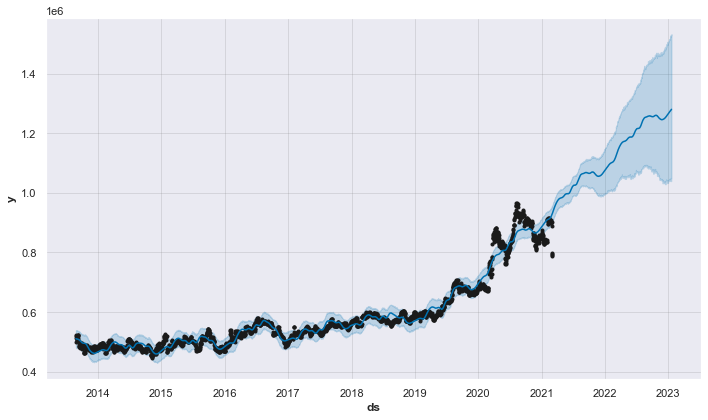

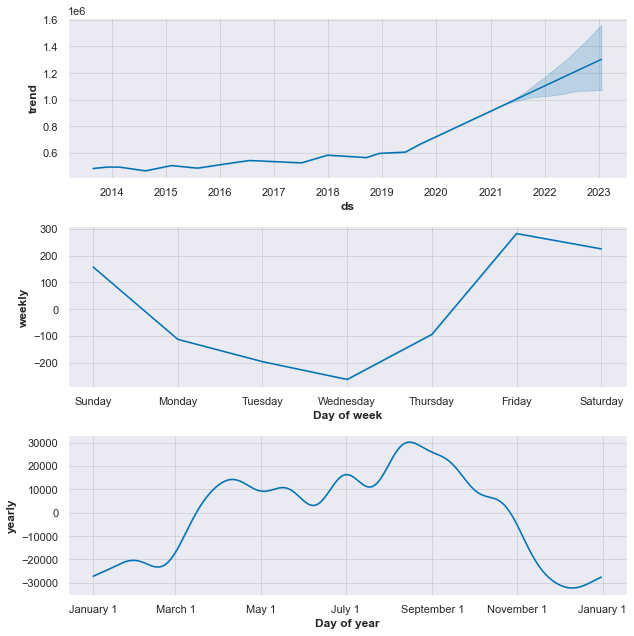

In [142]:
from prophet import Prophet
os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan"
tabel_emas_prophet = tabel_emas.copy()
tabel_emas_prophet.columns = ['ds','y','kurs_dolar_rp','n_case_corona']
bagi_ruang_test = int(tabel_emas_prophet.shape[0]*0.2)
tabel_emas_prophet_tr = tabel_emas_prophet[:-bagi_ruang_test]
tabel_emas_prophet_te = tabel_emas_prophet[-bagi_ruang_test:]
model_prophet = Prophet()
# model_prophet.add_regressor('kurs_dolar_rp')
# model_prophet.add_regressor('n_case_corona')

model_prophet.fit(tabel_emas_prophet_tr)
future = model_prophet.make_future_dataframe(periods=len(tabel_emas_prophet_te))
# future['kurs_dolar_rp'] = tabel_emas_prophet.kurs_dolar_rp
# future['n_case_corona'] = tabel_emas_prophet.n_case_corona
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
model_prophet.plot_components(forecast)
plt.show()

from sklearn.metrics import mean_absolute_percentage_error
mape_prophet_plain = mean_absolute_percentage_error(tabel_emas_prophet_te.y,forecast['yhat'][-bagi_ruang_test:])

14:47:32 - cmdstanpy - INFO - Chain [1] start processing
14:47:34 - cmdstanpy - INFO - Chain [1] done processing


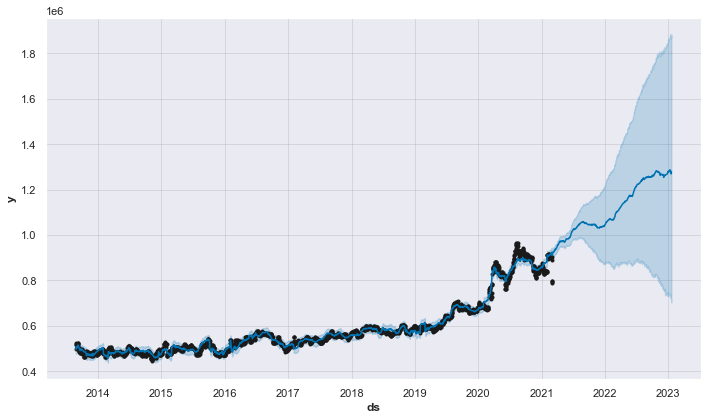

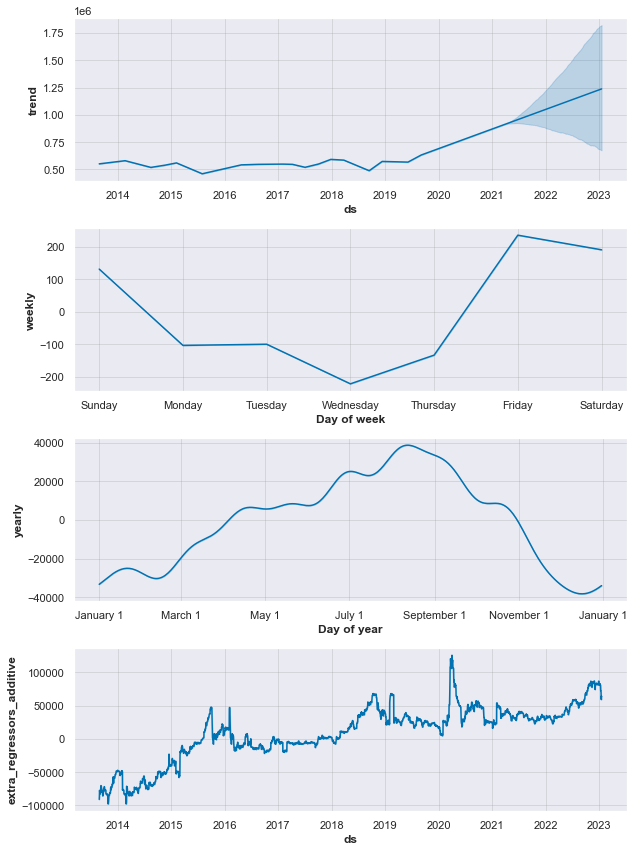

In [143]:
from prophet import Prophet
os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan"
tabel_emas_prophet = tabel_emas.copy()
tabel_emas_prophet.columns = ['ds','y','kurs_dolar_rp','n_case_corona']
bagi_ruang_test = int(tabel_emas_prophet.shape[0]*0.2)
tabel_emas_prophet_tr = tabel_emas_prophet[:-bagi_ruang_test]
tabel_emas_prophet_te = tabel_emas_prophet[-bagi_ruang_test:]
model_prophet = Prophet()
model_prophet.add_regressor('kurs_dolar_rp')
# model_prophet.add_regressor('n_case_corona')

model_prophet.fit(tabel_emas_prophet_tr)
future = model_prophet.make_future_dataframe(periods=len(tabel_emas_prophet_te))
future['kurs_dolar_rp'] = tabel_emas_prophet.kurs_dolar_rp
# future['n_case_corona'] = tabel_emas_prophet.n_case_corona
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
model_prophet.plot_components(forecast)
plt.show()

from sklearn.metrics import mean_absolute_percentage_error
mape_prophet_kurs = mean_absolute_percentage_error(tabel_emas_prophet_te.y,forecast['yhat'][-bagi_ruang_test:])

14:47:40 - cmdstanpy - INFO - Chain [1] start processing
14:47:43 - cmdstanpy - INFO - Chain [1] done processing


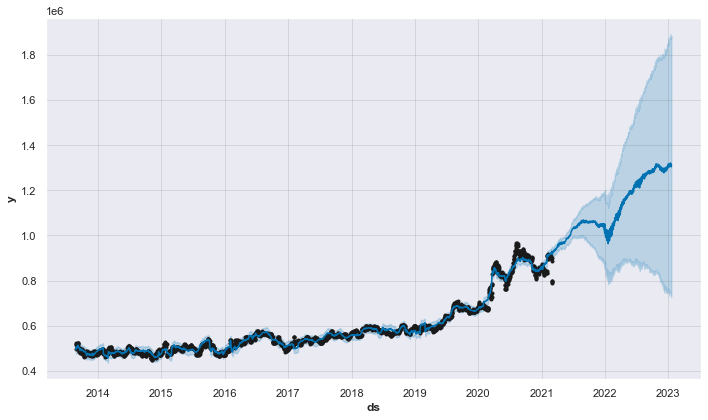

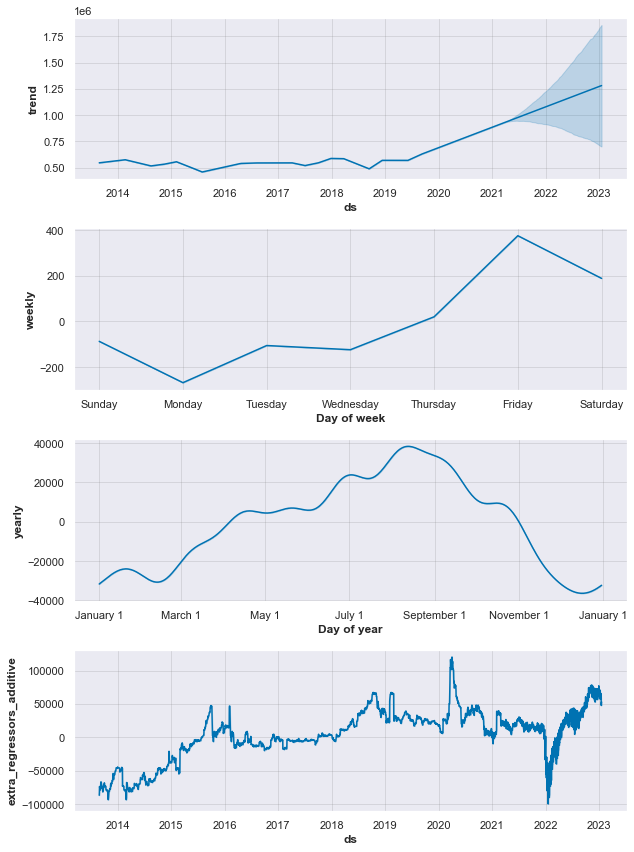

In [144]:
from prophet import Prophet
os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan"
tabel_emas_prophet = tabel_emas.copy()
tabel_emas_prophet.columns = ['ds','y','kurs_dolar_rp','n_case_corona']
bagi_ruang_test = int(tabel_emas_prophet.shape[0]*0.2)
tabel_emas_prophet_tr = tabel_emas_prophet[:-bagi_ruang_test]
tabel_emas_prophet_te = tabel_emas_prophet[-bagi_ruang_test:]
model_prophet = Prophet()
model_prophet.add_regressor('kurs_dolar_rp')
model_prophet.add_regressor('n_case_corona')

model_prophet.fit(tabel_emas_prophet_tr)
future = model_prophet.make_future_dataframe(periods=len(tabel_emas_prophet_te))
future['kurs_dolar_rp'] = tabel_emas_prophet.kurs_dolar_rp
future['n_case_corona'] = tabel_emas_prophet.n_case_corona
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
model_prophet.plot_components(forecast)
plt.show()

from sklearn.metrics import mean_absolute_percentage_error
mape_prophet_kurs_corona = mean_absolute_percentage_error(tabel_emas_prophet_te.y,forecast['yhat'][-bagi_ruang_test:])

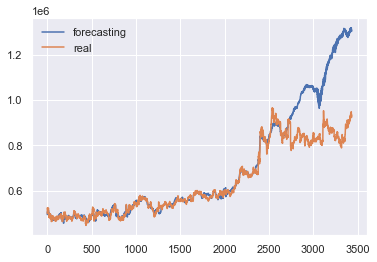

In [145]:
plt.plot(forecast['yhat'],label="forecasting")
plt.plot(tabel_emas_prophet.y,label="real")
plt.legend()
plt.show()

14:50:33 - cmdstanpy - INFO - Chain [1] start processing
14:50:35 - cmdstanpy - INFO - Chain [1] done processing


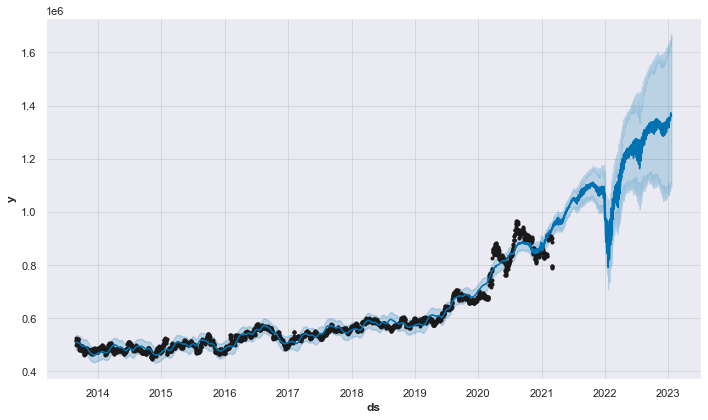

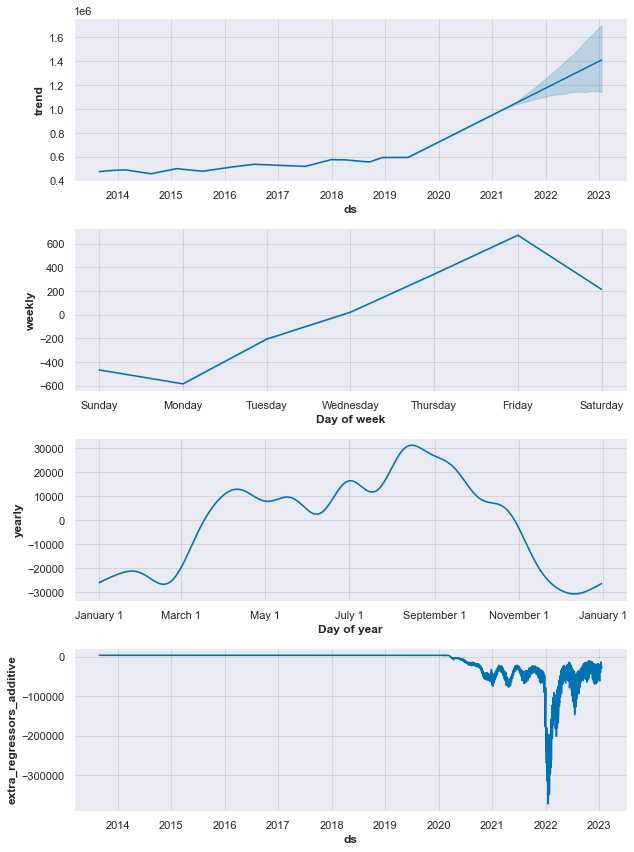

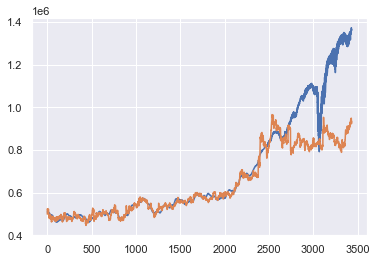

In [150]:
from prophet import Prophet
os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan"
tabel_emas_prophet = tabel_emas.copy()
tabel_emas_prophet.columns = ['ds','y','kurs_dolar_rp','n_case_corona']
bagi_ruang_test = int(tabel_emas_prophet.shape[0]*0.2)
tabel_emas_prophet_tr = tabel_emas_prophet[:-bagi_ruang_test]
tabel_emas_prophet_te = tabel_emas_prophet[-bagi_ruang_test:]
model_prophet = Prophet()
# model_prophet.add_regressor('kurs_dolar_rp')
model_prophet.add_regressor('n_case_corona')

model_prophet.fit(tabel_emas_prophet_tr)
future = model_prophet.make_future_dataframe(periods=len(tabel_emas_prophet_te))
# future['kurs_dolar_rp'] = tabel_emas_prophet.kurs_dolar_rp
future['n_case_corona'] = tabel_emas_prophet.n_case_corona
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
model_prophet.plot_components(forecast)
plt.show()
plt.plot(forecast['yhat'])
plt.plot(tabel_emas_prophet.y)
plt.show()

from sklearn.metrics import mean_absolute_percentage_error
mape_prophet_corona = mean_absolute_percentage_error(tabel_emas_prophet_te.y,forecast['yhat'][-bagi_ruang_test:])

In [151]:
print(f'mape_prophet_plain       : {mape_prophet_plain}')
print(f'mape_prophet_kurs        : {mape_prophet_kurs}')
print(f'mape_prophet_kurs_corona : {mape_prophet_kurs_corona}')
print(f'mape_prophet_corona      : {mape_prophet_corona}')


mape_prophet_plain       : 0.33099051653978867
mape_prophet_kurs        : 0.3181565456446891
mape_prophet_kurs_corona : 0.3237946992419071
mape_prophet_corona      : 0.3383787747546333


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15112\3703450730.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabel_emas_prophet_tr.y = std.fit_transform(tabel_emas_prophet_tr.y.to_numpy().reshape((-1,1)))
15:06:59 - cmdstanpy - INFO - Chain [1] start processing
15:07:01 - cmdstanpy - INFO - Chain [1] done processing


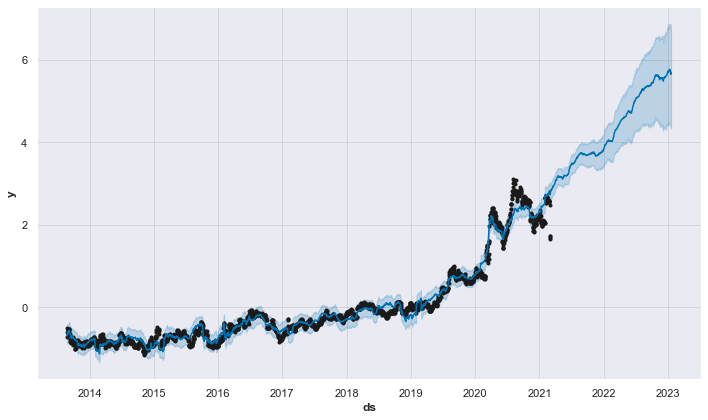

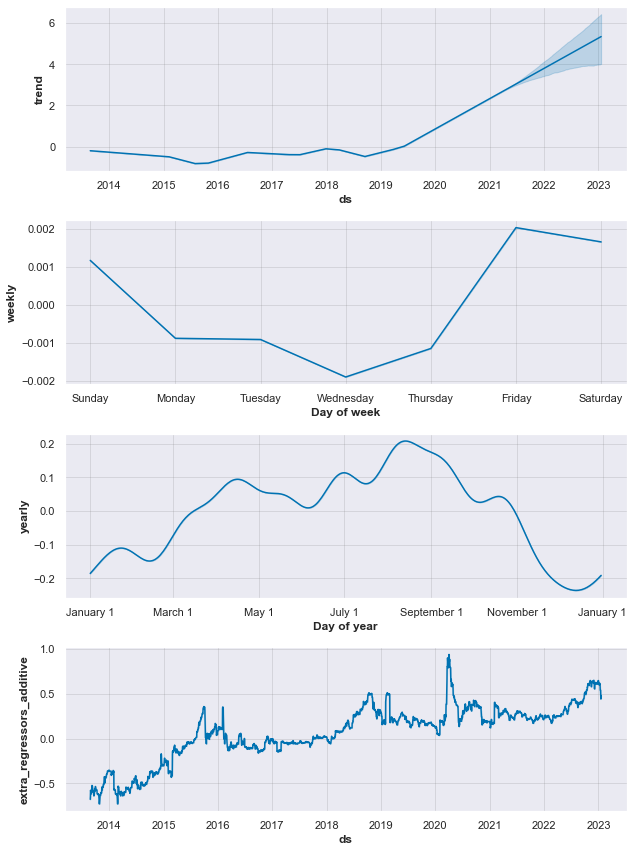

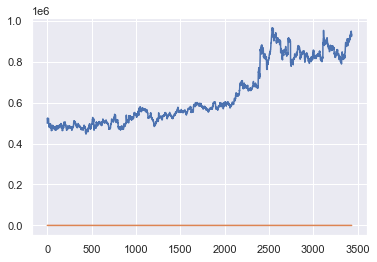

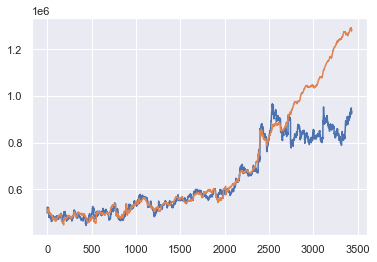

0.3150165443885052


In [163]:
from prophet import Prophet
from sklearn.preprocessing import StandardScaler,MinMaxScaler
os.environ['CMDSTAN'] = "C:/Users/ASUS/.conda/envs/ml/Library/bin/cmdstan"
tabel_emas_prophet = tabel_emas.copy()
tabel_emas_prophet.columns = ['ds','y','kurs_dolar_rp','n_case_corona']

std_dolar_rp = StandardScaler()
tabel_emas_prophet.kurs_dolar_rp = std_dolar_rp.fit_transform(tabel_emas_prophet.kurs_dolar_rp.to_numpy().reshape((-1,1)))

bagi_ruang_test = int(tabel_emas_prophet.shape[0]*0.2)
tabel_emas_prophet_tr = tabel_emas_prophet[:-bagi_ruang_test]
tabel_emas_prophet_te = tabel_emas_prophet[-bagi_ruang_test:]


std = StandardScaler()
tabel_emas_prophet_tr.y = std.fit_transform(tabel_emas_prophet_tr.y.to_numpy().reshape((-1,1)))

model_prophet = Prophet()
model_prophet.add_regressor('kurs_dolar_rp')
# model_prophet.add_regressor('n_case_corona')

model_prophet.fit(tabel_emas_prophet_tr)
future = model_prophet.make_future_dataframe(periods=len(tabel_emas_prophet_te))
future['kurs_dolar_rp'] = tabel_emas_prophet.kurs_dolar_rp
# future['n_case_corona'] = tabel_emas_prophet.n_case_corona
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
model_prophet.plot_components(forecast)
plt.show()

forecast['yhat'] = std.inverse_transform(forecast['yhat'].to_numpy().reshape((-1,1)))

plt.plot(tabel_emas_prophet.y)
plt.plot(forecast['yhat'])
plt.show()


from sklearn.metrics import mean_absolute_percentage_error
mape_prophet_kurs_std = mean_absolute_percentage_error(tabel_emas_prophet_te.y,forecast['yhat'][-bagi_ruang_test:])
print(mape_prophet_kurs_std)

In [ ]:
# fig2 = model_prophet.plot_components(forecast)
# fig2
# plt.show()

m